In this notebook, your task is to build a sleep stage classification model for the [Haaglanden Medisch Centrum Sleep Staging Database](https://physionet.org/content/hmc-sleep-staging/1.1/) you examined in your last homework assignment.

# Important: Run this code cell each time you start a new session!

In [763]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install opencv-python
!pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import sklearn

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


# Step 1: Define the Problem You Are Trying to Solve

As a reminder, the goal of this dataset is to enable researchers to automatically identify sleep stages using polysomnographic (PSG) recordings. Given the large size of these recordings, we will work only work with data from 3 participants from this 151-person study. Patient recordings were randomly selected from a heterogeneous group of patients who were referred for PSG examination due to different sleep disorders.

Participants were instrumented with the minimal recommended set of sensors necessary to visually score sleep stages: four EEG (F4/M1, C4/M1, O2/M1, and C3/M2), two EOG (E1/M2 and E2/M2), one bipolar chin EMG, and one ECG (single modified lead II) data stream. Participants slept in the sleep clinic for one night. Their PSG recordings were reviewed and annotated by expert clinicians according to discrete 30-second windows. An example of this annotation process is shown below (note: this is merely an illustration and does not represent the true time-scale of the data):

<img src="https://drive.google.com/uc?id=1UnkMe1WmP813ZGyS7ynT_CMqP2Nr2do0" width=750px/>

All data was recorded at 256 Hz. For your convenience, the data has already been processed so that there is one `.csv` per participant in a folder called `data` with the following naming convention: `SN{subject_id}.csv`. These files have the following columns:

| Column # | Description |
|----------|-------------|
| 1 | Time in seconds|
| 2 | Annotation given by the sleep experts (W, N1, N2, N3, R) |
| 3–6 | EEG data |
| 7 | EMG data |
| 8–9 | EOG data |
| 10 | ECG data |

In this notebook, your goal will be to create a ***classification model*** that infers sleep stages from 30-second windows of PSG data.

# Step 2: Create Your Features and Labels

Remember the `.csv` file that you created in the previous homework? That file already contains all of the data you will need to train your model.

**(Part 1)** If you do not have the `.csv` file from the previous homework on your local machine, you can regenerate it by going back to the previous homework, re-running the entire notebook, and then downloading the `.csv` that gets created in that notebook's workspace (folder icon on the left side).

Once you have the file, return here and upload it to this notebook's workspace. Then, write a line of code that will load the data from this `.csv` file as a `DataFrame`.

In [764]:
df = pd.read_csv("psg_data.csv")

**(Part 2)** Write code that will store the labels as a `numpy` array called `y`.

In [765]:
label_mapping = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'R': 4}
df['Annotation'] = df['Annotation'].map(label_mapping)
y = df['Annotation'].values

**(Part 3)** Write code that will store the features as a `numpy` array called `x`.

*Hint:* Remember that there are more columns in this `DataFrame` than features and labels.

In [766]:
x = df.iloc[:, 3:].values

# Step 3: Decide How the Data Should Be Split for Training and Testing

Recall that although our dataset only has one recording for each patient, we split those recordings into multiple windows. If we were to do a single 80%-20% split, we would likely have a single patient's data divided across the train and test sets, which is particularly problematic for this dataset because consecutive windows from the same patient are likely to be highly similar. Instead, you will need to use subject-wise cross-validation to generate one split for each patient in the dataset.

**(Part 4)** Write code that will store the group ID associated with each sample as a `numpy` array called `groups`.

In [767]:
groups = df['Subject ID'].values

You will actually perform the cross-validation in Step 8.

# Step 4: (Optional) Add Feature Selection

In [768]:
from sklearn.feature_selection import SelectPercentile, f_regression

feat_select = SelectPercentile(f_regression, percentile=60)
x = feat_select.fit_transform(x, y)

# Step 5: (Optional) Balance Your Dataset

In [769]:
# from imblearn.over_sampling import SMOTE

# x_resampled = []
# y_resampled = []

# for subject in np.unique(groups):
#     # Select data for the current subject
#     index = groups == subject
#     x_subject = x[index]
#     y_subject = y[index]

#     # Apply SMOTE to balance the data for the current subject
#     smote = SMOTE()
#     x_resampled_subject, y_resampled_subject = smote.fit_resample(x_subject, y_subject)

#     # Append the resampled data to the overall lists
#     x_resampled.append(x_resampled_subject)
#     y_resampled.append(y_resampled_subject)

# # Combine the resampled data for all subjects
# x_balanced = np.concatenate(x_resampled)
# y_balanced = np.concatenate(y_resampled)

# x = x_balanced
# y = y_balanced

# # Create a new groups array reflecting the balanced data
# groups_balanced = []
# for i, subject in enumerate(np.unique(groups)):
#     groups_balanced.extend([subject] * len(y_resampled[i]))

# groups_balanced = np.array(groups_balanced)

# groups = groups_balanced

# Step 6: Select an Appropriate Model

You should use a `RandomForestClassifier` as your model architecture for this assignment. You will actually initialize this model in Step 8.

# Step 7: (Optional) Select Your Hyperparameters

In [770]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100, 200, 300, 400],
              'criterion' : ['gini', 'entropy', 'log_loss'],
              'max_depth': [2, 5, 10, None]}

clf = RandomForestClassifier()
num_patients = len(np.unique(groups))
grid_search_clf = GridSearchCV(clf, param_grid,
                           cv=num_patients)
grid_search_clf.fit(x, y)
best_params = grid_search_clf.best_params_
print(f'Best Params: {grid_search_clf.best_params_}')
print(f'Best Score: {grid_search_clf.best_score_}')

Best Params: {'criterion': 'log_loss', 'max_depth': 10, 'n_estimators': 50}
Best Score: 0.5758258258258259


# Step 8: Train and Test Your Model

We could perform the entire cross-validation procedure using the function `cross_val_predict()` we covered in our Parkinsonian Gait regression task:

In [771]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

clf = RandomForestClassifier(**best_params)
num_patients = len(np.unique(groups))
y_pred = cross_val_predict(clf, x, y, groups=groups, cv=num_patients)
print(y_pred)

[0 0 0 ... 0 0 0]


However, it's good to get familiar with how to write these routines on your own for situations when you need to train and test models in another way.

**(Part 5)** Write a program that will evaluate the performance of a `RandomForestClassifier` using subject-wise cross-validation. Some pseudocode is provided below.

*Hint:* Unlike with previous examples, the labels for this dataset are strings. You could convert the strings to a number (W = 0, N1 = 1, ...). However, it will be hard to interpret your results if you don't reverse the conversion after you train and test your models. Instead, you can use the following line to initialize the data structure for your results: `y_pred = np.empty(y.shape, dtype=object)`.

*Hint:* You can use [`GroupKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) like we did in the lecture, but you may also consider using [`LeaveOneGroupOut`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html#sklearn.model_selection.LeaveOneGroupOut). As the name implies, this function is similar to `GroupKFold`, but if assumes that the number of folds is equal to the number of groups you would like to keep distinct.

```
initialize a data structure for saving our final results
for each fold:
    split data into train and test
    train a model on training data
    predict on the test data using that model
    add the predictions to our final results data structure
```

In [772]:
from sklearn.model_selection import LeaveOneGroupOut

y_pred = np.empty(y.shape, dtype=object)
logo = LeaveOneGroupOut()
for train_index, test_index in logo.split(x, y, groups):
  x_train, x_test = x[train_index], x[test_index]
  y_train, y_test = y[train_index], y[test_index]
  clf = RandomForestClassifier()
  clf.fit(x_train, y_train)
  y_pred[test_index] = clf.predict(x_test)
print(y_pred)

[0 0 0 ... 1 1 0]


# Step 9: Use an Appropriate Method for Interpreting Results

**(Part 6)** Create a confusion matrix showing the accuracy of your model.

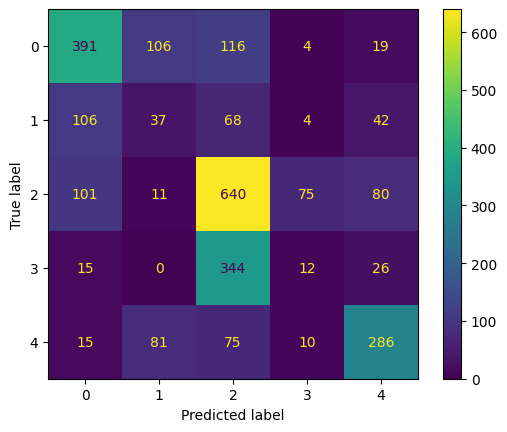

In [773]:
from sklearn.metrics import ConfusionMatrixDisplay

# Convert y_pred to the same type as y
y_pred = y_pred.astype(y.dtype)

ConfusionMatrixDisplay.from_predictions(y, y_pred)
plt.show()

**(Part 7)** Calculate the overall accuracy of your model.

In [774]:
from sklearn.metrics import accuracy_score

print(f'Accuracy: {accuracy_score(y, y_pred)}')

Accuracy: 0.5127627627627628


**(Part 8)** What can you tell about your model based on these results? Is it particularly successful at classifying some sleep stages over others? Does it tend to get some stages confused with one another?

The model has a low overall accuracy when classifying sleep stages. It is most successful at classifying the N2 followed by W, less successful at classifying N3 and R, and poor at classifying N1. Based on these results, I predict that the model would have a higher accuracy if tasked with only classifying between wake and sleep without stages.